In [5]:
import pandas as pd
import numpy as np
import re
import scipy as sp
import scipy.stats as sts
# !pip install shap
import shap
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
import random
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
random.seed(42)


<a id='ab'></a>
##  A/B тестирование. Практика

A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель и улучшают ли.

Типичное применение в веб-дизайне — исследование влияния цветовой схемы, расположения и размера элементов интерфейса на конверсию сайта.

Конверсия (Conversion Rate) в интернет-маркетинге — это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах. 



В теории принципы A/B тестирования невероятно просты:

- Выдвигаем предположение о том, что какое-то изменение (например, персонализация главной страницы) увеличит конверсию интернет-магазина.

- Создаем альтернативную версию сайта «Б» — копию исходной версии «А» с изменениями, от которых мы ждем роста эффективности сайта.

- Всех посетителей сайта случайным образом делим на две равные группы: одной группе показываем исходный вариант (контрольная группа) , второй группе (тестовой) — альтернативный. Одновременно измеряем конверсию для обеих версий сайта.

- Определяем статистически достоверно победивший вариант.

Мы будем анализировать результаты A/B тестирования двух версий дизайна кнопки сайта интернет-магазина. 

Целевым действием считаем клик по этой кнопке. 

Первые три этапа А/В тестирования за нас провели, результаты предоставили в виде файла ab_dataset.csv. Нам осталось выполнить четвертый пункт.

## **Исследование улучшения конверсии сайта**

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Посмотрим, сколько посетителей заходило на сайт (количество строк в нашем датафрейме)

In [7]:
# Количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [8]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [9]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей.")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены {}".format(len(mismatch_2)) + " пользователей.\n")


Из тестовой группы неверно направлены 1965 пользователей.
Из контрольной группы неверно направлены 1928 пользователей.



In [10]:
# Удалим ошибочные экземпляры
df.drop(mismatch_1.index, axis=0, inplace=True)
df.drop(mismatch_2.index, axis=0, inplace=True)

In [11]:
n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 290585


Выясним, есть ли в данных пропуски.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   revenue       290585 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 15.5+ MB


Из сообщений следует, что пропущенных значений нет.

Конверсия по всем посетителям.

In [13]:
p_all=df['converted'].mean()
print("Конверсия по всем посетителям: {} %".format(p_all*100))

Конверсия по всем посетителям: 11.959667567149026 %


In [14]:
# Можно и так:
sum(df['converted'].values)/n_rows

0.11959667567149027

Давайте посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`) и постараемся получить ответы на следующие вопросы:

- Какова вероятность клика для посетителей из контрольной группы (старый дизайн)?

- Какова вероятность клика для посетителей из тестовой группы (новый дизайн кнопки)?

- Каково соотношение размеров тестовой и контрольный групп? Какова вероятность, что очередной посетитель будет направлен на версию со старым дизайном? С новым дизайном?

In [15]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                               ... revenue              
              count           mean           std  ...     50%    75%    max
group                                             ...                      
control    145274.0  788164.072594  91287.914601  ...     0.0  250.0  250.0
treatment  145311.0  787845.618446  91161.258854  ...   100.0  250.0  250.0

[2 rows x 24 columns]

In [16]:
# Объем контрольной группы
n_rows_contr = len(df[df['group'] == 'control'])

# Объем тестовой группы
n_rows_treat = n_rows-n_rows_contr

# Объем конверсии контрольной группы
n_rows_contr_cnvrd = len(df.query("group == 'control' and converted == 1"))

# Объем конверсии тестовой группы
n_rows_treat_cnvrd = len(df.query("group == 'treatment' and converted == 1"))

In [17]:
print("Вероятность клика для посетителей из контрольной группы (старый дизайн): {}".format(n_rows_contr_cnvrd/n_rows_contr))  # mean --> converted
print("Вероятность клика для посетителей из тестовой группы (новый дизайн кнопки): {}".format(n_rows_treat_cnvrd/n_rows_treat))  # mean --> converted

Вероятность клика для посетителей из контрольной группы (старый дизайн): 0.1203863045004612
Вероятность клика для посетителей из тестовой группы (новый дизайн кнопки): 0.11880724790277405


Ответы на остальные вопросы можно найти, например, так:

In [18]:
print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(n_rows_contr/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(n_rows_treat/n_rows))


Соотношение размеров тестовой и контрольной групп: 1.0002546911353718
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.4999363353235714
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.5000636646764286


**Задание**

А теперь ответьте на главный вопрос данного этапа:  выявил ли предварительный анализ, что дизайн кнопки влияет на конверсию и если да, то как именно?

**Ответ:** предварительный анализ показал, что вероятность клика для посетителей из тестовой группы чуть ниже, чем в контрольной, при этом вероятность перенаправления пользователя на сайт с новым дизайном чуть выше. Отсюда следует, что изменение дизайна не сильно повлияло на конверсию. Стоит отметить, что отличия в вероятности клика наблюдаются в сотом знаке после запятой, поэтому необходимо провести дополнительное исследование.

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: **"Конверсия сайта со старым дизайном не меньше, чем с новым"**.

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения, т.е. доли, кликнувших посетителей в контрольной и тестовой выборках.

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [19]:
import statsmodels.api as sm
import statsmodels

convert_contr = sum(df.query("group == 'control'")['converted'])
convert_treat = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_treat, convert_contr], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print("Z-статистика={},  p_value={}".format(z_score, p_value))

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


Z-статистика=-1.3116075339133115,  p_value=0.905173705140591


#### Проведение вычислений. $T$-test.

In [20]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['converted'],
                                                              df.query("group == 'control'")['converted'],
                                                              alternative="larger",
                                                              usevar='unequal')

print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=-1.3116059499580377,  p_value=0.9051729196326528


#### Проведение вычислений. $Mann–Whitney$-test.

In [21]:
w_score, p_value = sp.stats.mannwhitneyu(df.query("group == 'treatment'")['converted'], 
                         df.query("group == 'control'")['converted'],
                         alternative="greater")

print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=10538288235.5,  p_value=0.9051733308476495


**Задание**

Посмотрели на результаты стат тестов, какая гипотеза оказалась верна?

**Ответ:** Чтобы принять или отвергнуть гипотезу, нужно обозначить уровень значимости $\alpha$. Примем значение $\alpha = 0.05$, тогда значение $Z$-критерия будет лежать в пределах от $-1,96$ до $+1,96$. А значение $p-value$ будет выше значения $\alpha$. Связи с этим, мы не можем отвергнуть гипотезу $H_0$. Таким образом, заключим, что **конверсия сайта со старым дизайном не меньше, чем с новым**.

<a id='m12'></a>
### Ошибки первого и второго рода

|  | | | |
|----------|:---------|:--------|:---------|
|  | | 	Верная гипотеза: | |
|  |     | $H_0$   | $H_1$    |
| Результат применения критерия: | $H_0$   |$H_0$ верно принята  |$H_0$ неверно принята (ошибка II рода)  |  
|  |$H_1$   |$H_0$ неверно отвергнута(ошибка I рода)  | $H_0$ верно отвергнута   |



Уровень значимости (статистическая значимость, statistical significance) $\alpha$ - это и есть вероятность ошибки первого рода, т. е. вероятность принятия альтернативной гипотезы при условии, что на самом деле верна нулевая гипотеза. 

Обозначим  $\beta$  вероятность ошибки второго рода. 

Величина  $1-\beta$ называется *статистической мощностью* (statistical power) критерия. По сути мощность показывает, сколько значений, соответствующих альтернативной гипотезе, мы действительно отнесем к альтернативной гипотезе

![asd](https://habrastorage.org/files/475/9e5/ebc/4759e5ebcfc54b11a852704017d2d8ac.png)

![mem](https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg?fit=960%2C720&ssl=1)

### bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [22]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


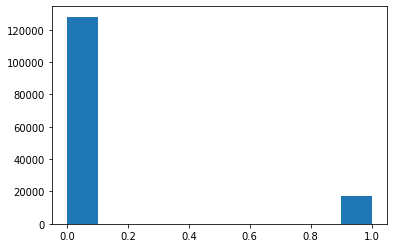

In [23]:
plt.hist(df.loc[df['group']=='treatment', 'converted']);

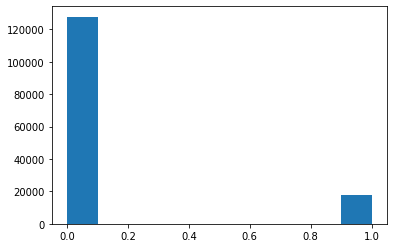

In [24]:
plt.hist(df.loc[df['group']=='control', 'converted']);

In [25]:
b = df.loc[df['group']=='treatment', 'converted'].values
a = df.loc[df['group']=='control', 'converted'].values

In [26]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

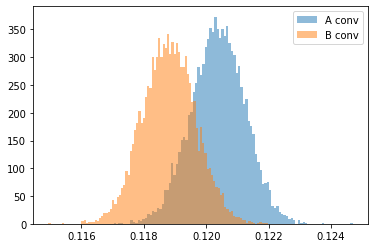

In [27]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [28]:
# Доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(0.1186929526274488, 0.12203835510827815)

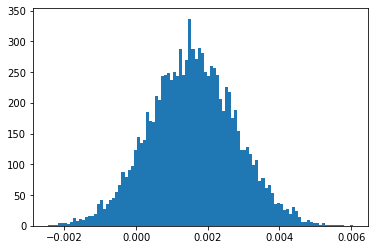

In [29]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [30]:
# Сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.9062

**Вывод:** Новый дизайн не увеличил конверсию сайта.

## **Исследование увеличения среднего чека**

**Задание**

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

 <a id='eda'></a>
### Первичный анализ данных

In [50]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Средний чек по всем посетителям.

In [51]:
r_all = df['revenue'].mean()
print("Средний чек по всем посетителям: {} %".format(r_all))

Средний чек по всем посетителям: 101.98272450401775 %


In [52]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                               ... revenue              
              count           mean           std  ...     50%    75%    max
group                                             ...                      
control    145274.0  788164.072594  91287.914601  ...     0.0  250.0  250.0
treatment  145311.0  787845.618446  91161.258854  ...   100.0  250.0  250.0

[2 rows x 24 columns]

In [53]:
print("Средний чек контрольной группы: {}".format((df[df['group'] == 'control']['revenue']).mean()))  # mean --> revenue
print("Средний чек тестовой группы: {}".format((df[df['group'] == 'treatment']['revenue']).mean()))  # mean --> revenue

Средний чек контрольной группы: 87.46678689923868
Средний чек тестовой группы: 116.49496596954118


In [54]:
# Объем контрольной группы со средним чеком 0
n_rows_contr_rev_0 = len(df.query("group == 'control' and revenue == 0"))

# Объем контрольной группы со средним чеком 100
n_rows_contr_rev_100 = len(df.query("group == 'control' and revenue == 100"))

# Объем контрольной группы со средним чеком 250
n_rows_contr_rev_250 = len(df.query("group == 'control' and revenue == 250"))

# Объем тестовой группы со средним чеком 0
n_rows_treat_rev_0 = len(df.query("group == 'treatment' and revenue == 0"))

# Объем тестовой группы со средним чеком 100
n_rows_treat_rev_100 = len(df.query("group == 'treatment' and revenue == 100"))

# Объем тестовой группы со средним чеком 250
n_rows_treat_rev_250 = len(df.query("group == 'treatment' and revenue == 250"))

In [55]:
print("Доля посетителей со средним чеком 0 контрольной группы (старый дизайн): {}".format(n_rows_contr_rev_0/n_rows_contr))
print("Доля посетителей со средним чеком 100 контрольной группы (старый дизайн): {}".format(n_rows_contr_rev_100/n_rows_contr))
print("Доля посетителей со средним чеком 250 контрольной группы (старый дизайн): {}".format(n_rows_contr_rev_250/n_rows_contr))

Доля посетителей со средним чеком 0 контрольной группы (старый дизайн): 0.5012665721326597
Доля посетителей со средним чеком 100 контрольной группы (старый дизайн): 0.24811046711730936
Доля посетителей со средним чеком 250 контрольной группы (старый дизайн): 0.250622960750031


In [56]:
print("Доля посетителей со средним чеком 0 тестовой группы (новый дизайн): {}".format(n_rows_treat_rev_0/n_rows_treat))
print("Доля посетителей со средним чеком 100 тестовой группы (новый дизайн): {}".format(n_rows_treat_rev_100/n_rows_treat))
print("Доля посетителей со средним чеком 250 тестовой группы (новый дизайн): {}".format(n_rows_treat_rev_250/n_rows_treat))

Доля посетителей со средним чеком 0 тестовой группы (новый дизайн): 0.3340283942715968
Доля посетителей со средним чеком 100 тестовой группы (новый дизайн): 0.33331956975039745
Доля посетителей со средним чеком 250 тестовой группы (новый дизайн): 0.3326520359780058


**Вывод:** предварительный анализ показал, что средний чек у тестовой группы выше, чем у контрольной. Как по общему показателю, так и в разрезе сумм 100 и 250. Также у тестовой группы меньше доля посетителей без покупок.

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза может быть сформулирована так: **"Средний чек при старом дизайне не ниже, чем при новом"**.

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Задача выяснить, случайно или значимо отличаются средние значения покупок в контрольной и тестовой выборках.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


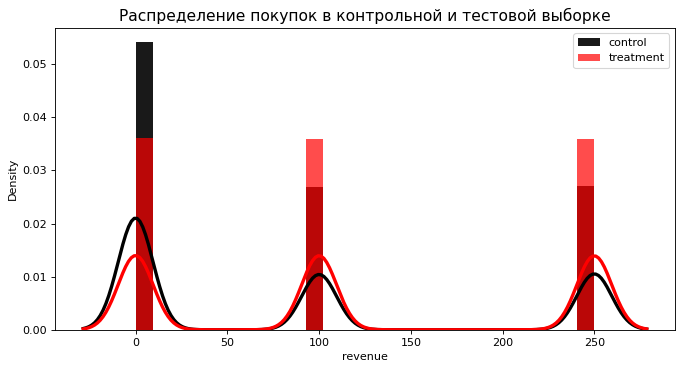

In [57]:
plt.figure(figsize=(10,5), dpi= 80)
sns.distplot(df.loc[df['group'] == 'control', "revenue"], color="black", label="control", hist_kws={'alpha':.9}, kde_kws={'linewidth':3})
sns.distplot(df.loc[df['group'] == 'treatment', "revenue"], color="red", label="treatment", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

plt.title('Распределение покупок в контрольной и тестовой выборке', fontsize=14)
plt.legend()
plt.show()

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [58]:
import statsmodels.api as sm
import statsmodels

revenue_contr_len = len(df.query("group == 'control' and revenue != 0"))
revenue_treat_len = len(df.query("group == 'treatment' and revenue != 0"))

z_score, p_value = sm.stats.proportions_ztest([revenue_treat_len,revenue_contr_len], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print("Z-статистика={},  p_value={}".format(z_score, p_value))


Z-статистика=91.39989084875799,  p_value=0.0


#### Проведение вычислений. $T$-test.

In [59]:
revenue_contr = df.query("group == 'control'")['revenue']
revenue_treat = df.query("group == 'treatment'")['revenue']

t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(revenue_treat,
                                                              revenue_contr,
                                                              alternative="larger",
                                                              usevar='unequal')

print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.26758637238547,  p_value=0.0


#### Проведение вычислений. $Mann–Whitney$-test.

In [60]:
w_score, p_value = sp.stats.mannwhitneyu(revenue_treat, 
                                         revenue_contr,
                                         alternative="greater")

print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=12309559045.0,  p_value=0.0


**Ответ:** Обозначим уровень значимости $\alpha = 0.05$, тогда значение $Z$-критерия будет больше $+1,96$. А значение $p-value$ будет ниже значения $\alpha$. Связи с этим, мы не можем принять гипотезу $H_0$. Таким образом, можно заключить, что **средний чек при старом дизайне ниже, чем при новом**.

### bootstrap  
Сделаем стат выводы при помощи bootstrap-а

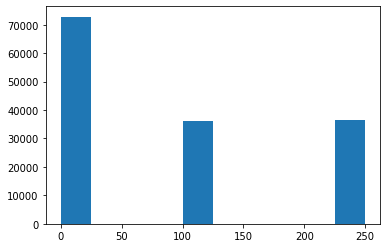

In [42]:
plt.hist(df.loc[df['group']=='control', 'revenue']);

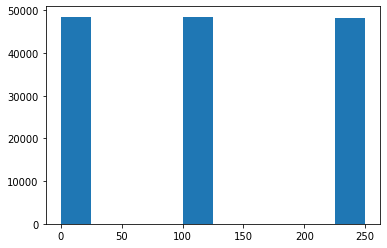

In [43]:
plt.hist(df.loc[df['group']=='treatment', 'revenue']);

In [44]:
a = df.loc[df['group']=='control', 'revenue'].values
b = df.loc[df['group']=='treatment', 'revenue'].values

In [45]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

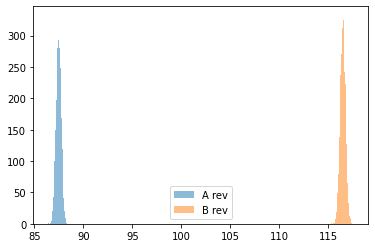

In [46]:
plt.hist(a_means, label='A rev', alpha=0.5, bins=100)
plt.hist(b_means, label='B rev', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [47]:
# Доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.94603817613613, 87.99889347026998)

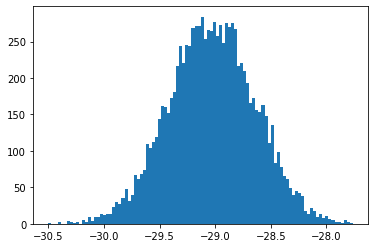

In [48]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [49]:
# Сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

**Вывод:** На сайте с новым дизайном увеличился средний чек.

### Домашнее задание. Теория

**1. Если мы рассчитали 95% доверительный интервал для среднего значения, то какие из следующих утверждений являются верными?**

Выберите несколько вариантов и попытайтесь объяснить свой выбор:

1) Если многократно повторять эксперимент, то 95 % выборочных средних значений будут принадлежать рассчитанному нами доверительному интервалу.

**ВЕРНО** 2) Мы можем быть на 95% уверены, что среднее значение в генеральной совокупности принадлежит рассчитанному доверительному интервалу.

**ВЕРНО** 3) Если многократно повторять эксперимент, для каждой выборки рассчитывать свой доверительный интервал, то в 95 % случаев истинное среднее будет находиться внутри доверительного интервала.

4) Среднее значение в генеральной совокупности точно превышает нижнюю границу 95% доверительного интервала.

5) Среднее значение в генеральной совокупности точно принадлежит рассчитанному доверительному интервалу.



**Ответ:** 2) и 3).

Первое утверждение неверно, так как мы сравниваем доверительный интервал со средним значением генеральной совокупности, а не со средним значением конкретной выборки.

Четвертое и пятое утверждения неверны, так как 95% описывают вероятность попадания среднего значения генеральной совокупности в доверительный интервал и не могут быть описаны как точная граница.



**2. Если мы увеличиваем объем выборки в два раза (при условии, что показатель стандартного отклонения остается неизменным), то 95% доверительный интервал?**

Выберите один вариант из списка

**ВЕРНО** 1) стал более узким

2) возможны оба варианта

3) стал более широким



**Ответ:** 1).

**3. В центре 95% доверительного интервала, рассчитанного по выборочным значениям, находится:**

Выберите один вариант из списка

1) Значение стандартной ошибки среднего

**ВЕРНО** 2) Выборочное среднее значение

3) Среднее значение генеральной совокупности



**Ответ:** 2).

**4. Часто на практике нулевая гипотеза отклоняется, и различия считаются статистически достоверными, если p < 0,05. Однако часто в статистике используется более жесткий критерий достоверности различий, например, при условии, что p < 0,01. Значение p-уровня значимости, которое выбирается, в качестве порога обозначается буквой α (альфа). Например, если исследователь решил, что α = 0,05, то и нулевая гипотеза будет отклоняться при условии, что p < 0,05.**

**Если в определенной ситуации весьма рискованно отклонить нулевую гипотезу, когда она на самом деле верна, то лучше использовать показатель α равный?** 

Выберите один вариант из списка

1) 0,1

**ВЕРНО** 2) 0,001

3) 0,05

4) 0,5



**Ответ:** 2).

**5. Данные некоторого исследования сообщают нам, что средний рост детей в 14 лет составляет 166 сантиметров. Однако это лишь выборочная оценка, и исследователи рассчитали 95% доверительный интервал, который составил [160, 172]. Укажите верные утверждения:**

Выберите несколько вариантов и попытайтесь объяснить свой выбор:

**ВЕРНО** 1) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 173

2) Вероятность того, что истинное среднее значение больше 172, составляет 0,01

**ВЕРНО** 3) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 158.

4) Доверительный интервал не может иметь такие границы, т. к. выборочное стандартное отклонение равняется 10, следовательно доверительный интервал должен быть значительно шире.



**Ответ:** 1) и 3).

Второе утверждение неверно, так как нет достаточно оснований утверждать, что 0,01 является вероятностью того, что истинное среднее значение больше 172.

Четвертое утверждение неверно, так как из условия задачи мы не можем достоверно определить чему равняется выборочное стандартное отклонение.

**6. Предположим, нулевой гипотезой вашего исследования являлось предположение, что конверсия в генеральной совокупности равняется 0.4. Вы получили p = 0,12 и не смогли отклонить нулевую гипотезу. Однако позже выяснилось, что конверсия в генеральной совокупности действиетльно равна 0.4. Как можно оценить результаты?**


Какой вариант корректный по вашему мнению и почему?

**ВЕРНО** 1) Вы не совершали ни ошибку первого рода, ни ошибку второго рода.

2) Вы совершили ошибку первого рода

3) Вы совершили ошибку второго рода

**Ответ:** 1).

В результате исследования была принята нулевая гипотеза, притом что нулевая гипотеза оказалось верной. Следовательно, ошибка первого рода, что нулевая гипотеза отвергнула, не была совершена. Ошибка второго рода, что нулевая гипотеза принята ошибочно, также не совершалась.